### Pre-process data

In [23]:
import pandas as pd
import numpy as np
from sktime.annotation.hmm_learn import GaussianHMM 
from hmmlearn import hmm
import matplotlib.pyplot as plt
import os


def load_data(data_dir='../data/interim'):
    """
    Load all CSV files from the specified directory and returns a list of dataframes
    ---
    Returns:
        dataframes: a list of dataframes; each dataframe is a patient's data with specific pre-processing configuration loaded from the csv files
    """
    csv_files = [f for f in os.listdir(data_dir) if f.endswith('.csv')]
    
    dataframes = []
    for file in csv_files:
        df = pd.read_csv(os.path.join(data_dir, file))
        # df['patient_id'] = file.split('_')[0]  # Extract patient ID from filename
        dataframes.append(df)
    print(f"Loaded data from {len(csv_files)} files.")
    
    # combined_df = pd.concat(dataframes, ignore_index=True, axis=0)
    combined_df = dataframes[0]
    
    # Return first pre-processed data for testing
    return combined_df

column_to_select = ["date", "bgl", "msg_type", "day_start_shift", "bgl_rate"]
def process_data(df, inter_order=3, window_size=3, use_exp=False):
    """
    Process blood glucose level data with smoothing.
    
    Args:
        df: DataFrame containing the BGL data
        inter_order: polynomial interpolation order
        window_size: Size of the rolling window for smoothing (default=3 measurements = 15 minutes)
    Returns:
        DataFrame with processed and smoothed data
    """
    time_delta = window_size * 5
    print("time_delta: ", time_delta, " mins")
    
    df['date'] = pd.to_datetime(df['date'])
    df['bgl'] = df['bgl'].interpolate(method='polynomial', order=inter_order)
    
    if use_exp:
        # Exponential weighted average
        df['bgl'] = df['bgl'].ewm(span=window_size, adjust=False).mean()
        df['bgl'] = df['bgl'].ffill().bfill()
        
        df['bgl_rate'] = df['bgl'].diff() / 5.0
        df['bgl_rate'] = df['bgl_rate'].ewm(span=window_size, adjust=False).mean()
        df['bgl_rate'] = df['bgl_rate'].ffill().bfill()
    else:
        # Rolling average
        df['bgl'] = df['bgl'].rolling(span=window_size, center=False).mean()
        df['bgl'] = df['bgl'].ffill().bfill()
        
        df['bgl_rate'] = df['bgl'].diff() / 5.0
        df['bgl_rate'] = df['bgl_rate'].rolling(window=window_size, center=False).mean()
        df['bgl_rate'] = df['bgl_rate'].ffill().bfill()
    
    first_day = df['day_start_shift'].min()
    last_day = df['day_start_shift'].max()
    
    # Omit first and last day because there is some missing data due to rolling mean
    df = df[(df['day_start_shift'] > first_day) & (df['day_start_shift'] < last_day)]
    
    return df[column_to_select]

def create_features(df, rate_threshold=0):
    """
    Create features with one-hot encoding for categorical variables.
    
    Parameters:
    df: DataFrame with columns ['msg_type', 'bgl_rate']
    rate_threshold: threshold for determining trend
    
    Returns:
    DataFrame with one-hot encoded features
    """
    result = df.copy()
    
    # Event type: 0 = None, 1 = Meal, 2 = Insulin
    result['event_type'] = 0
    result.loc[result['msg_type'] == 'ANNOUNCE_MEAL', 'event_type'] = 1
    result.loc[result['msg_type'] == 'DOSE_INSULIN', 'event_type'] = 2
    
    # Trend: -1 = Downward, 0 = Stable, 1 = Upward
    result['trend'] = 0
    result.loc[result['bgl_rate'] > rate_threshold, 'trend'] = 1
    result.loc[result['bgl_rate'] < -rate_threshold, 'trend'] = -1
    
    # Create one-hot encodings
    event_dummies = pd.get_dummies(result['event_type'], prefix='event')
    trend_dummies = pd.get_dummies(result['trend'], prefix='trend')
    
    # Add one-hot encoded columns to result
    result = pd.concat([
        result,
        event_dummies,
        trend_dummies
    ], axis=1)
    
    # Drop original categorical columns if you don't need them
    result = result.drop(['event_type', 'trend'], axis=1)
    
    return result

    
def scale_features(df, columns_to_scale=['bgl', 'bgl_rate']):
    """
    Normalize specific numerical features in a DataFrame
    
    Args:
        df : Input DataFrame with features to scale
        columns_to_scale : List of column names to scale
    Returns:
        scaled_df : DataFrame with scaled features
        means : Dictionary of means for each scaled column
        stds : Dictionary of standard deviations for each scaled column
    """
    scaled_df = df.copy()
    means = {}
    stds = {}
    
    for col in columns_to_scale:
        means[col] = df[col].mean()
        stds[col] = df[col].std()
        scaled_df[col] = (df[col] - means[col]) / stds[col]
    
    return scaled_df, means, stds


def split_temporal_data(df, test_size=0.3):
    """
    Split dataframe into train and test sets based on desired proportion of total data
    
    Args:
        df : Input dataframe with 'day_start_shift' column
        test_size : Desired proportion of data for testing (default: 0.3)
        
    Returns:
        train_df : Training data in whole day
        test_df : Testing data in whole day
    """
    # Get counts for each day
    day_counts = df['day_start_shift'].nunique()

    
    first_day = df['day_start_shift'].min()
    days = int(day_counts * (1 - test_size))
    split_day = pd.to_datetime(first_day) + pd.Timedelta(days=days)
    split_day = split_day.strftime('%Y-%m-%d')
    
    # Split days
    train_df = df[df['day_start_shift'] <= split_day].copy()
    test_df = df[df['day_start_shift'] > split_day].copy()
    
    # Print actual split proportions
    print("Total days: ", day_counts)
    print("Split day: ", split_day)
    print(f"Train set size: {len(train_df)} ({len(train_df)/len(df):.2%})")
    print(f"Test set size: {len(test_df)} ({len(test_df)/len(df):.2%})")
    
    return train_df, test_df, day_counts

## Visualization of data


Loaded data from 21 files.
time_delta:  20  mins
Total days:  91
Split day:  2024-09-11
Train set size: 21024 (80.22%)
Test set size: 5184 (19.78%)


,date,bgl,msg_type,day_start_shift,bgl_rate,event_0,event_1,event_2,trend_-1,trend_1
48,2024-07-01 04:00:00-05:00,-0.810185,NaN,2024-07-01,-0.566607,True,False,False,True,False
49,2024-07-01 04:05:00-05:00,-0.853480,NaN,2024-07-01,-0.554326,True,False,False,True,False
50,2024-07-01 04:10:00-05:00,-0.879457,NaN,2024-07-01,-0.461198,True,False,False,True,False
51,2024-07-01 04:15:00-05:00,-0.895043,NaN,2024-07-01,-0.353866,True,False,False,True,False
52,2024-07-01 04:20:00-05:00,-0.862778,NaN,2024-07-01,-0.052504,True,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...
21067,2024-09-12 03:35:00-05:00,-1.056401,NaN,2024-09-11,-0.068059,True,False,False,True,False
21068,2024-09-12 03:40:00-05:00,-1.052747,NaN,2024-09-11,-0.022706,True,False,False,True,False
21069,2024-09-12 03:45:00-05:00,-1.052019,NaN,2024-09-11,-0.009981,True,False,False,True,False
21070,2024-09-12 03:50:00-05:00,-1.054373,NaN,2024-09-11,-0.017607,True,False,False,True,False


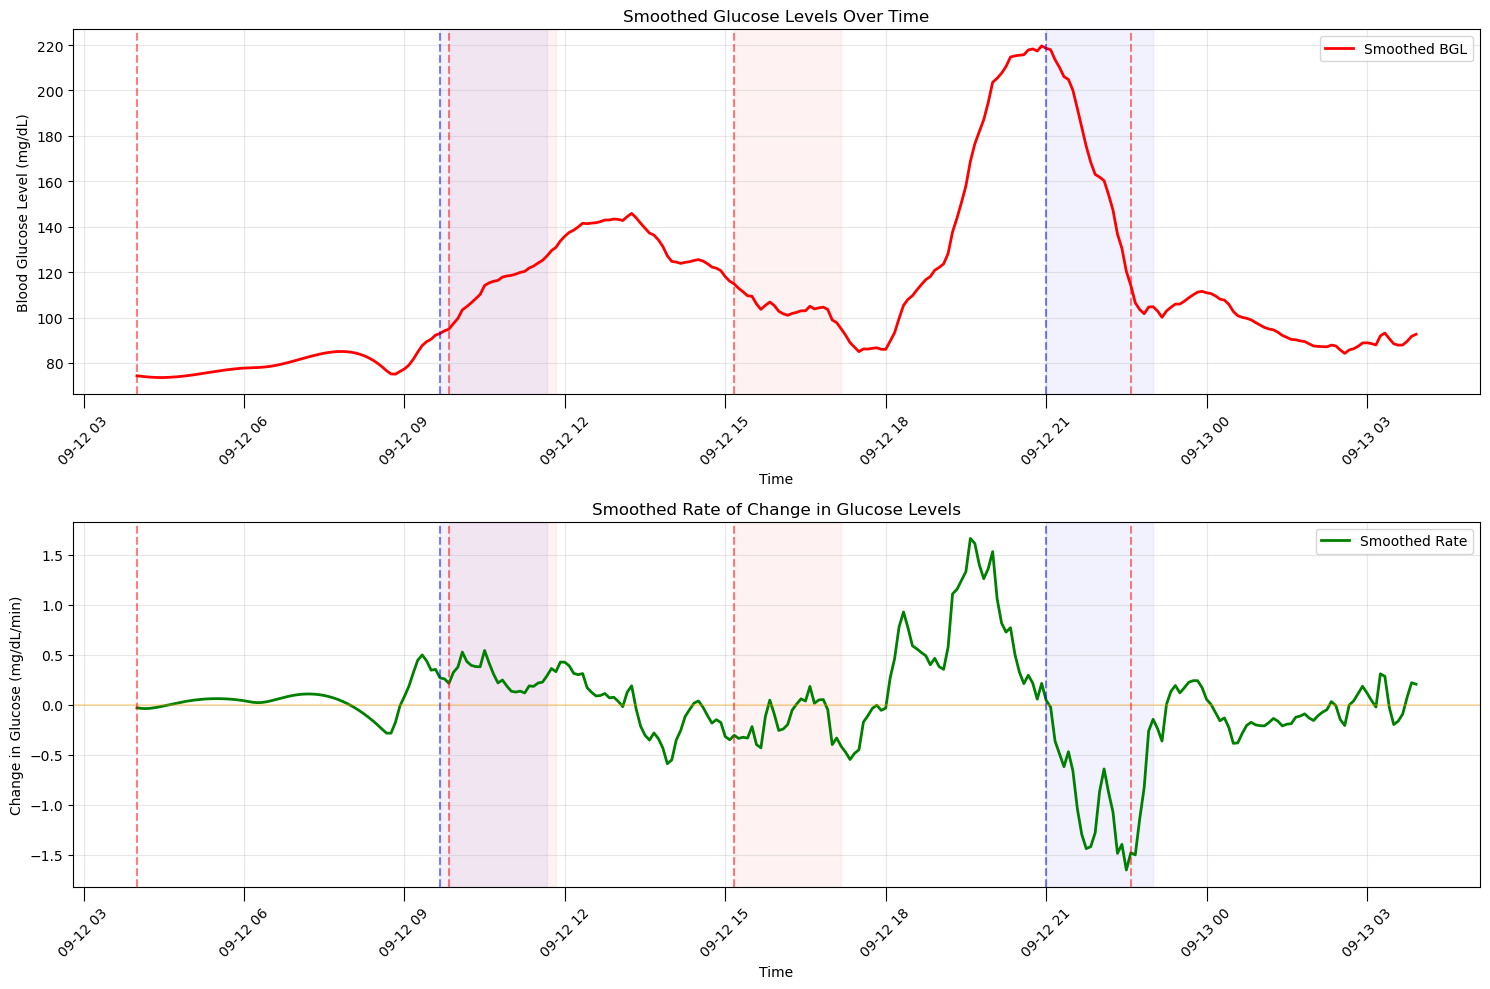

In [62]:
def plot_event_lines(ax1, ax2, event_times, color, linestyle, alpha, label, highlight_duration=None, use_label=True):
    for event_time in event_times:
        for ax in [ax1, ax2]:
            if use_label:
                ax.axvline(x=event_time, color=color, linestyle=linestyle, alpha=alpha, label=label)
            else:
                ax.axvline(x=event_time, color=color, linestyle=linestyle, alpha=alpha)
            if highlight_duration:
                ax.axvspan(event_time, event_time + highlight_duration, color=color, alpha=0.05)

def plot_glucose_levels(df, use_label=True):
    # Create figure
    fig, axs = plt.subplots(2, 1, figsize=(15, 10))
    
    ax1 = axs[0]
    ax1.plot(df['date'], df['bgl'], color='r', linewidth=2, label='Smoothed BGL')
    ax1.set_title('Smoothed Glucose Levels Over Time', fontsize=12)
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Blood Glucose Level (mg/dL)')
    ax1.grid(True, alpha=0.3)
    ax1.tick_params(axis='x', rotation=45, length=10)

    ax2 = axs[1]
    ax2.plot(df['date'], df['bgl_rate'], color='g', linewidth=2, label='Smoothed Rate')
    ax2.axhline(y=0, color='orange', linestyle='-', alpha=0.3)
    ax2.set_title('Smoothed Rate of Change in Glucose Levels', fontsize=12)
    ax2.set_xlabel('Time')
    ax2.set_ylabel('Change in Glucose (mg/dL/min)')
    ax2.grid(True, alpha=0.3)
    ax2.tick_params(axis='x', rotation=45, length=10)
    

    meal_times = []
    snack_times = []
    insulin_times = []
    if 'msg_type' in df.columns:
        meal_times = df[df['msg_type'].str.contains('MEAL', na=False)]['date']
        snack_times = df[df['msg_type'].str.contains('SNACK', na=False)]['date']
        insulin_times = df[df['msg_type'].str.contains('INSULIN', na=False)]['date']
        
    highlight_delta = np.timedelta64(2, 'h')
    plot_event_lines(ax1, ax2, meal_times, color='r', linestyle='--', alpha=0.5, label='Meal', highlight_duration=highlight_delta, use_label=use_label)
    plot_event_lines(ax1, ax2, snack_times, color='r', linestyle='--', alpha=0.5, label='Snack', use_label=use_label)
    plot_event_lines(ax1, ax2, insulin_times, color='b', linestyle='--', alpha=0.5, label='Insulin', highlight_duration=highlight_delta, use_label=use_label)
    
    # Adjust layout
    ax1.legend()
    ax2.legend()
    plt.tight_layout()
    
    return fig


pre_processed_df = load_data()

""" Generate rate of change """
window_size = 4
processed_df = process_data(pre_processed_df, window_size=window_size, use_exp=True)
processed_df = create_features(processed_df)

""" Scale the feature """
test_df,  means, stds = scale_features(processed_df)
train_df, test_df, day_counts = split_temporal_data(test_df, test_size=0.2)

""" Sample data """
start_date = pd.to_datetime("2024-09-12")
end_date = start_date + pd.Timedelta(days=1)
processed_df['day_start_shift'] = pd.to_datetime(processed_df['day_start_shift'])
sample_df = processed_df[(processed_df['day_start_shift'] >= start_date) & 
                         (processed_df['day_start_shift'] < end_date)]

fig1 = plot_glucose_levels(sample_df, use_label=False)
train_df

### Train data
1. Use a period of time to train the data using only bgl, a week, a month ...
2. Try to label the data 

In [63]:
def fit_hmm_model_daily(X,  n_states=2, n_tries=10, random_state=42, verbose=False):
    # Prepare each day as a time series to fit the model
    day_indices = X['day_start_shift'].values
    unique_days = np.unique(day_indices)
    
    # Split each dat to a sequence
    sequences = []
    for day in unique_days:
        day_data = X[day_indices == day]
        features = np.column_stack([
            # Continuous features
            day_data['bgl'].values,
            day_data['bgl_rate'].values,
            # day_data['trend_-1'].values,
            # day_data['trend_1'].values,
        ])
        sequences.append(features)
    
    # Get lengths and concatenate for model
    lengths = [len(seq) for seq in sequences]
    X_concat = np.concatenate(sequences)
    
    if verbose:
        print(f"X_concat shape: {X_concat.shape}")
        print(f"Sum of lengths: {sum(lengths)} should equal {X_concat.shape[0]}")
    
    best_score = float('-inf')
    best_model = None
    
    # Maybe we need a random seed?
    for try_idx in range(n_tries):
        model = hmm.GaussianHMM(
            n_components=n_states,
            covariance_type="full",
            n_iter=1000,
            init_params="stmc",
            random_state=random_state + try_idx
        )
    
        try:
            model.fit(X_concat, lengths=lengths)
            total_score = model.score(X_concat, lengths=lengths)

            if total_score > best_score:
                if verbose:
                    print(f"Found better model with score: {total_score} (previous: {best_score})")
                best_score = total_score
                best_model = model
        except Exception as e:
            if verbose:
                print(f"Try {try_idx} failed with error: {str(e)}")
            continue

    if best_model is None:
        raise ValueError("Failed to fit model after multiple attempts")

    return best_model, best_score

model, score = fit_hmm_model_daily(train_df, n_states=2, n_tries=25, verbose=True)
print("model: ", model)
print("score: ", score)


X_concat shape: (21024, 2)
Sum of lengths: 21024 should equal 21024
Found better model with score: -47454.8814790739 (previous: -inf)
Found better model with score: -47454.87923400269 (previous: -47454.8814790739)
model:  GaussianHMM(covariance_type='full', n_components=2, n_iter=1000,
            random_state=47)
score:  -47454.87923400269


## Train and predict real life data

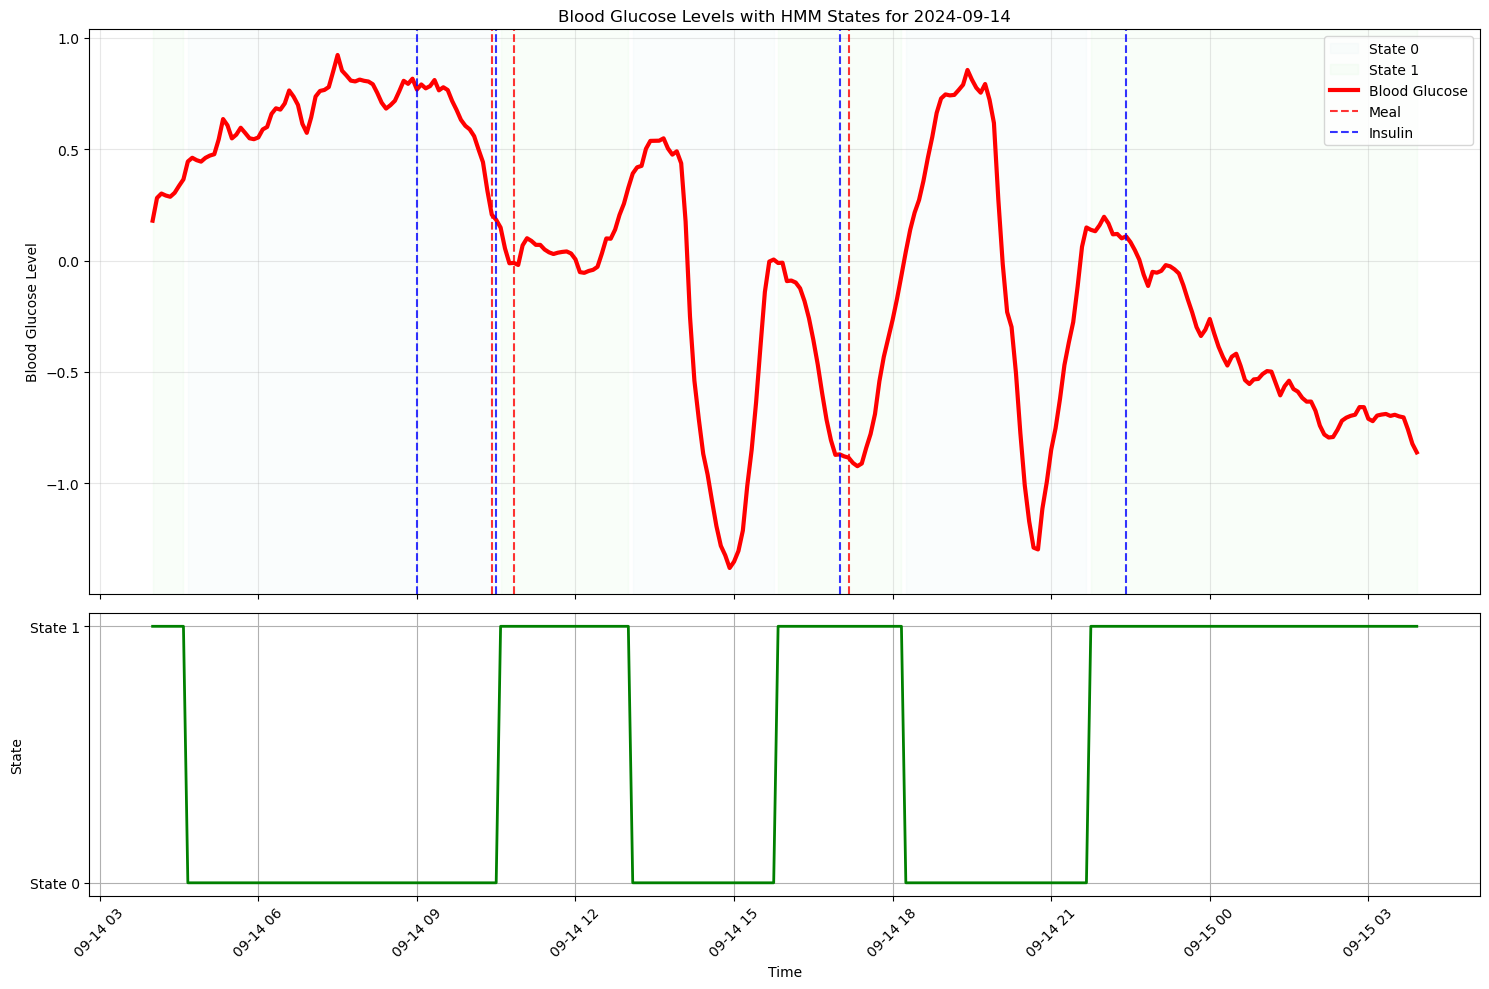

In [64]:
def plot_hmm_annotations(model, test_df, day=None):
    """
    Plot HMM state annotations for glucose data using both colored backgrounds and state subplot
    
    Parameters:
    model: fitted HMM model
    test_df: test dataframe with columns ['date', 'bgl', 'bgl_rate', 'day_start_shift']
    day: specific day to plot (optional)
    """
    
    # If no specific day, take the first day
    if day is None:
        day = test_df['day_start_shift'].iloc[0]
    
    # Get data for the specified day
    day_data = test_df[test_df['day_start_shift'] == day]
    
    # Prepare features
    features = np.column_stack([
        day_data['bgl'].values,
        day_data['bgl_rate'].values,
        # day_data['trend_-1'].values,
        # day_data['trend_1'].values,
    ])
    states = model.predict(features)
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), height_ratios=[2, 1], sharex=True)
    
    dates = pd.to_datetime(day_data['date'])
    colors = ['lightblue', 'lightgreen', 'lightyellow', 'lightpink']
    
    # Plot colored backgrounds for states in the first subplot
    unique_states = np.unique(states)
    y_min, y_max = day_data['bgl'].min(), day_data['bgl'].max()
    padding = (y_max - y_min) * 0.1  # Add 10% padding
    
    for state in unique_states:
        state_mask = states == state
        dates_array = dates.values
        ax1.fill_between(dates_array, 
                        y_min - padding,
                        y_max + padding,
                        where=state_mask,
                        alpha=0.05,
                        color=colors[state],
                        label=f'State {state}')
    
    ax1.plot(dates, day_data['bgl'], 'r-', linewidth=3, label='Blood Glucose')
    if 'msg_type' in day_data.columns:
        meal_times = day_data[day_data['msg_type'].str.contains('MEAL|INTERVENTION_SNACK', na=False)]['date']
        insulin_times = day_data[day_data['msg_type'].str.contains('INSULIN', na=False)]['date']
        for meal_time in meal_times:
            ax1.axvline(x=meal_time, color='r', linestyle='--', alpha=0.8, label='Meal' if meal_time == meal_times.iloc[0] else '')
        for insulin_time in insulin_times:
            ax1.axvline(x=insulin_time, color='b', linestyle='--', alpha=0.8, label='Insulin' if insulin_time == insulin_times.iloc[0] else '')
    
    
    ax1.set_ylabel('Blood Glucose Level')
    ax1.set_title(f'Blood Glucose Levels with HMM States for {day}')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    ax2.plot(dates, states, 'g-', linewidth=2, label='HMM State')
    ax2.set_ylabel('State')
    ax2.set_xlabel('Time')
    ax2.grid(True)
    ax2.set_yticks(range(model.n_components))
    ax2.set_yticklabels([f'State {i}' for i in range(model.n_components)])
    
    plt.xticks(rotation=45)
    plt.tight_layout()
        
    return fig

# Plot a specific day (starting from 09-12)
test_day = "2024-09-14"
first_test_day_df = test_df[test_df['day_start_shift'] == test_day]

fig_predict = plot_hmm_annotations(model, test_df, test_day)
plt.show()